In [5]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})
#%config InlineBackend.figure_format='retina'

In [56]:
def embedded_rk4_ode(f, y0, h0, xlim, abstol=0, reltol=1e-7, hminmax=(1e-30, 1e30),
                     max_iterations=2**30, should_trim_endpoint=True):
    """Approximate the solution of y' = f(y, x) by embedded 4th-order Runge-Kutta method.
    
    :param f:
        Right-hand side of the differential equation y' = f(y, x).
    :param y0:
        Initial value y0 = y(x0) where x0 is the first element of list xlim.
    :param h0:
        Initial stepsize.
    :param xlim:
        A pair of values denoting the integral limit.
    :param abstol=float:
        Absolute error tolerence needed.
    :param reltol=float:
        Relative error tolerence needed.
    :param hminmax=(hmin, hmax):
        The minimum and maximum stepsizes in which the next stepsize must lie.
    :param max_iterations=integer:
        The maximum number of iterations allowed.
    :param should_trim_endpoint=boolean:
        If True, modify the last approximation to the value at x = xlim[1].
        
    :return:
    Returns x values, y values, and step sizes.
    """

    x0, xf = xlim

    # table
    a2 , a3 , a4 , a5 , a6  = 1/5, 3/10, 3/5, 1, 7/8
    b21, b31, b41, b51, b61 = 1/5, 3/40, 3/10, -11/54, 1631/55296
    b32, b42, b52, b62      = 9/40, -9/10, 5/2, 175/512
    b43, b53, b63           = 6/5, -70/27, 575/13824
    b54, b64                = 35/27, 44275/110592
    b65                     = 253/4096
    #
    c1, c2, c3, c4, c5, c6  = 37/378, 0, 250/621, 125/594, 0, 512/1771
    d1, d2, d3              = c1 - 2825/27648, c2 - 0, c3 - 18575/48384
    d4, d5, d6              = c4 - 13525/55296, c5 - 277/14336, c6 - 1/4

    def single_step(x, y, h):
        k1 = h*f(x       , y)
        k2 = h*f(x + a2*h, y + b21*k1)
        k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
        k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
        k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
        k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)
        
        # approximation of y
        y = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6
        x = x + h

        # error estimate
        delta = d1*k1 + d2*k2 + d3*k3 + d4*k4 + d5*k5 + d6*k6
        
        y_tmp = abs(y) + abs(h*k1) # this is to prevent y ≈ 0
        desired = abs(abstol) + abs(y_tmp*reltol)
        rel_err = delta / desired
        if type(rel_err) is not float:                                  # in case of ndarray,
            rel_err = np.sqrt(sum(rel_err.flatten()**2) / len(rel_err)) # take square norm

        # next step size
        h = h / max(abs(rel_err)**0.2, 1e-2)    # limit the max stepsize increase
        h = min(max(h, hminmax[0]), hminmax[1]) # finally, clamp stepsize
    
        return x, y, h
    
    # loop
    xs = [x0]
    ys = [y0]
    hs = [h0]
    i  = 0
    while i < max_iterations and x0 < xf:
        x0, y0, h0 = single_step(x0, y0, h0)
        xs.append(x0)
        ys.append(y0)
        hs.append(h0)
        i += 1
        
    if should_trim_endpoint:
        xs[-1], ys[-1], _ = single_step(xs[-2], ys[-2], xf - xs[-2])
    
    return xs, ys, hs

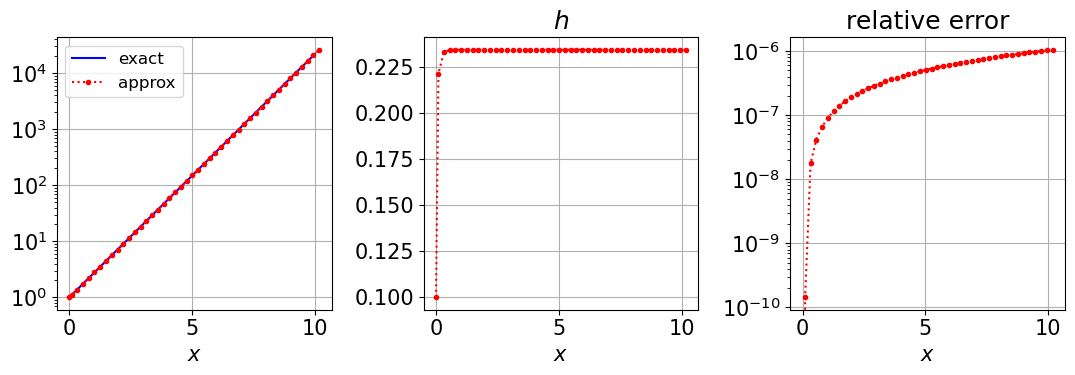

45


In [89]:
xlim = 0, 10

x_true = np.linspace(*xlim, 200)
y_true = np.exp(x_true)

xs, ys, hs = embedded_rk4_ode(lambda x, y: y, 1, 0.1, xlim, reltol=1e-7,
                              hminmax=(1e-10, 1), max_iterations=100,
                              should_trim_endpoint=False)
error = [abs(x - y)/abs(y) for x, y in zip(ys, np.exp(xs))]

plt.figure(figsize=[11, 4])

plt.subplot(1, 3, 1)
plt.semilogy(x_true, y_true, "-b", xs, np.array(ys) , ".:r") #그냥 ys 해도 됨. 이미 array type이기에.
plt.legend(["exact", "approx"], fontsize=12) 
plt.grid()
plt.xlabel("$x$")

plt.subplot(1, 3, 2)
plt.plot(xs, hs, ".:r")
plt.grid()3
plt.xlabel("$x$")
plt.title("$h$")

plt.subplot(1, 3, 3)
plt.semilogy(xs, error, ".:r")
plt.grid()
plt.xlabel("$x$")
plt.title("relative error")

plt.tight_layout()
plt.show()

print(len(xs))

In [39]:
print(len(xs))

45


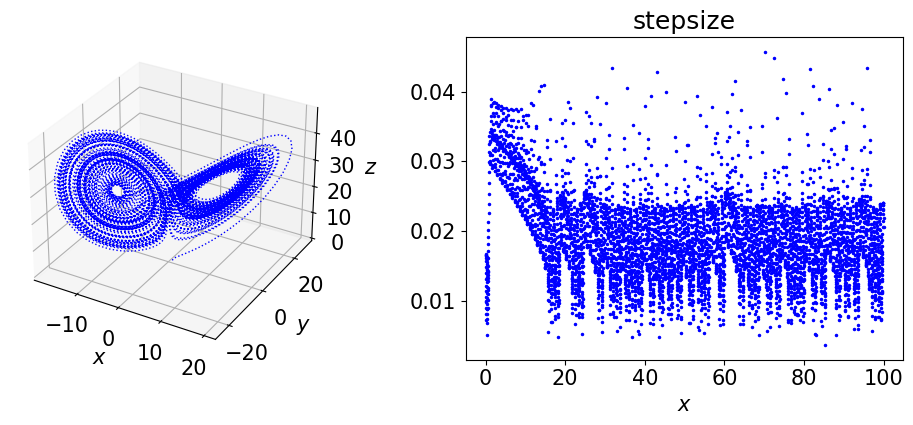

In [95]:
def F(t, Y):
    [x, y, z] = Y
    dY = 10*(y - x), x*(28 - z) - y, x*y - z*8/3
    return np.array(dY)

Yinit = np.array([1, 0, 0]) # x0, y0, z0
hinit = 0.01
xlim = 0, 100
t, Y, h = embedded_rk4_ode(F, Yinit, hinit, xlim, abstol=1e-10, reltol=1e-7,
                           hminmax=(1e-10, 1), max_iterations=100000, should_trim_endpoint=True)

x, y, z = map(np.array, zip(*Y))

plt.figure(figsize=(10, 4.5))

ax = plt.subplot(1, 2, 1, projection="3d")
plt.plot(x, y, z, ":b", lw=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

ax = plt.subplot(1, 2, 2)
plt.plot(t, h, ".b", ms=3)
ax.set_xlabel("$x$")
ax.set_title("stepsize")


In [86]:
rel_err = np.array([1, 20])
print(rel_err)

[ 1 20]


In [96]:
if type(rel_err) is not float:  
    rel_err = np.sqrt(sum(rel_err.flatten()**2) / len(rel_err))
    print(rel_err)

TypeError: object of type 'numpy.float64' has no len()

In [103]:
embedded_rk4_ode(F, [1,5,23], hinit, xlim, abstol=1e-10, reltol=1e-7,
                           hminmax=(1e-10, 1), max_iterations=100000, should_trim_endpoint=True)

([0,
  0.01,
  0.0236800291385467,
  0.03831833065600608,
  0.05389191127191806,
  0.07036320269016377,
  0.08773876607333611,
  0.10604953745896031,
  0.12533397172616953,
  0.145615667922944,
  0.16687241609074255,
  0.1890004085718188,
  0.21179587198499675,
  0.23499266703708097,
  0.2583555894924991,
  0.28174352258685836,
  0.3050513013556355,
  0.3280421074517833,
  0.35028611862390563,
  0.37140594655118675,
  0.3911908886420591,
  0.4095716091306453,
  0.4267701759606078,
  0.4431682991749816,
  0.45910066920244214,
  0.47481789868474406,
  0.49051434623235374,
  0.5063579082061372,
  0.5225199599161838,
  0.5392137756851472,
  0.5567495905574638,
  0.575609506966205,
  0.5964209695339572,
  0.6185783163444656,
  0.6398535714948429,
  0.6603905963628397,
  0.6808032070418877,
  0.7015138559143418,
  0.7228973256980904,
  0.7453962770544491,
  0.7696874756540236,
  0.7972043871322027,
  0.834726442778613,
  0.8652469832537639,
  0.8912489663323901,
  0.9157211963573556,
  0.939

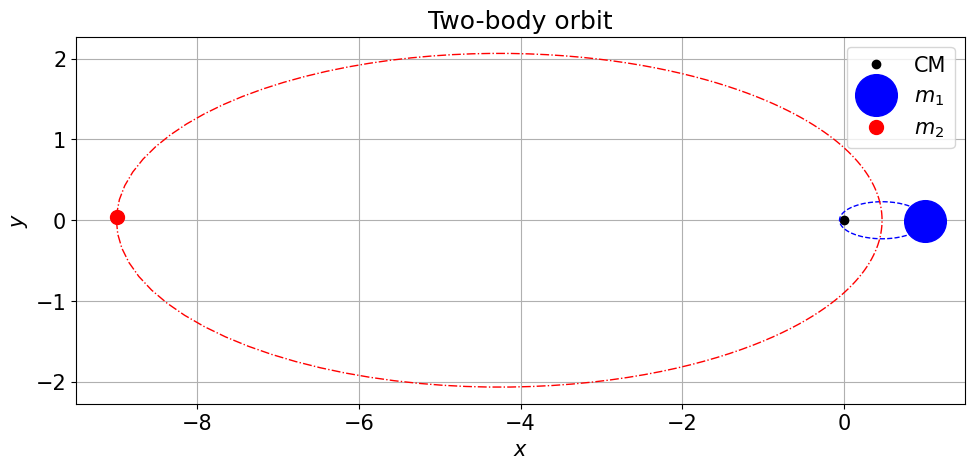

In [109]:
# constants
k, mu, L = 1, 1, 1

R0, r0 = 0, 10
V0, v0 = 0, L/(mu*r0)

# m1 is massive object and m2 is a satellite
m1 = 10
m2 = m1*mu / (m1 - mu)
assert m1 > 1 and m2 > 1, "masses must be greater than 1"

abstol = 1e-9
reltol = abstol

# initial values
RR_0 = np.array([0,  0])
VV_0 = np.array([V0, 0])
rr_0 = np.array([r0, 0])
vv_0 = np.array([0, v0])

xx1_0 = RR_0 + m2/(m1 + m2)*rr_0
xx2_0 = RR_0 - m1/(m1 + m2)*rr_0

vv1_0 = VV_0 + m2/(m1 + m2)*vv_0
vv2_0 = VV_0 - m1/(m1 + m2)*vv_0

Y_init = np.array([xx1_0, xx2_0, vv1_0, vv2_0])
h_init = 0.1
tlim   = 0, 24*np.pi

# derivatives
def F(t, Y):
    xx1, xx2, vv1, vv2 = Y
    r_squared = sum((xx1 - xx2)**2)
    F12 = -k/r_squared**1.5 * (xx1 - xx2)
    F21 = -F12
    return np.array([vv1, vv2, F12/m1, F21/m2])

# solve ode
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

# unpack result
xx1, xx2, vv1, vv2 = map(np.array, zip(*Y))

RR = (m1*xx1 + m2*xx2)/(m1 + m2)
VV = (m1*vv1 + m2*vv2)/(m1 + m2)

rr = xx1 - xx2
vv = vv1 - vv2

XX1 = xx1 - RR # position of m_1 in CM frame
XX2 = xx2 - RR # position of m_2 in CM frame

# drawing
plt.figure(figsize=[10, 10])

plt.subplot(1, 1, 1).set_aspect("equal")
plt.plot(0, 0, 'ok', label="CM")
plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$m_1$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$m_2$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Two-body orbit")

plt.tight_layout()
plt.show()

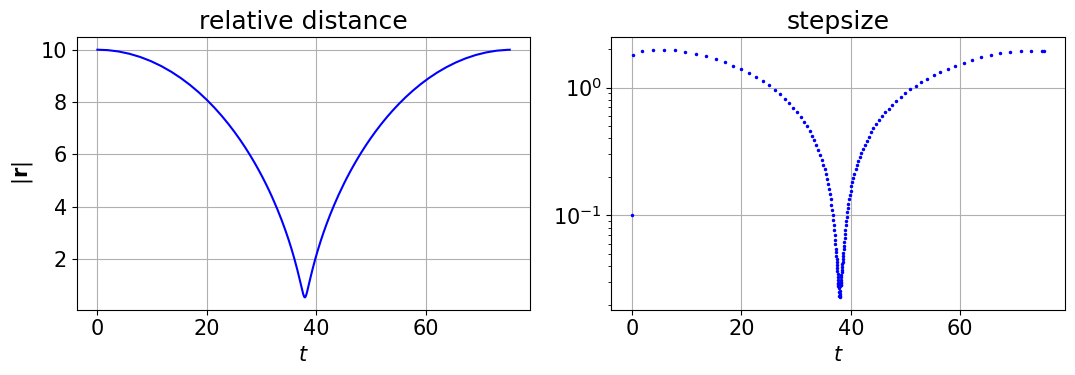

In [115]:
plt.figure(figsize=[11, 4])

plt.subplot(1, 2, 1)
plt.plot(t, [np.sqrt(x**2 + y**2) for x, y in rr], "-b", ms = 3)
plt.xlabel("$t$")
plt.ylabel("$|\\mathbf{r}|$")
plt.title("relative distance")
plt.grid()

plt.subplot(1, 2, 2)
plt.semilogy(t, h, ".b", ms=3)
plt.xlabel("$t$")
plt.title("stepsize")
plt.grid()

plt.tight_layout()
plt.show()

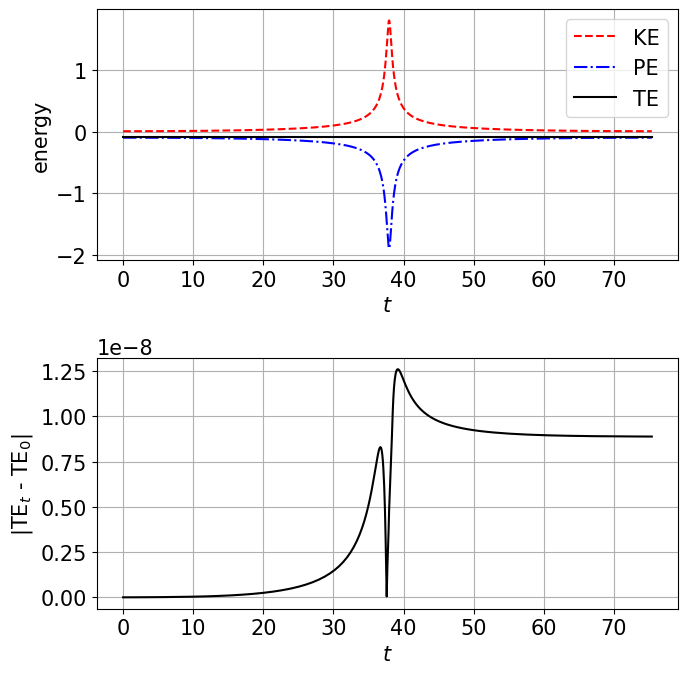

[-0.095, -0.095, -0.09500000000228856, -0.0950000000063602, -0.09500000001234231, -0.09500000002108529, -0.09500000003365167, -0.09500000005116419, -0.09500000007471217, -0.09500000010530019, -0.0950000001438378, -0.09500000019115645, -0.09500000024803729, -0.09500000031523868, -0.09500000039351716, -0.09500000048364224, -0.09500000058640362, -0.09500000070261341, -0.09500000083310263, -0.09500000097871261, -0.09500000114028068, -0.09500000131861996, -0.09500000151449127, -0.09500000172885135, -0.0950000019630891, -0.09500000221828872, -0.09500000249510743, -0.09500000279403256, -0.09500000311533319, -0.09500000345897597, -0.0950000038245146, -0.09500000421094276, -0.0950000046165039, -0.09500000503844469, -0.09500000547270804, -0.09500000591357027, -0.09500000635325012, -0.0950000067815659, -0.09500000718578444, -0.09500000755087223, -0.09500000786037843, -0.09500000809804265, -0.09500000824989874, -0.09500000830625743, -0.09500000826282284, -0.09500000812055065, -0.09500000788444485,

In [116]:
KE = [0.5*mu*(x + y)  for x, y in vv ** 2    ]
PE = [-k/(x + y)**0.5 for x, y in rr ** 2    ]
TE = [x + y           for x, y in zip(KE, PE)]

plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(t, KE, "--r", t, PE, "-.b", t, TE, "-k")
plt.legend(["KE", "PE", "TE"])
plt.grid()
plt.xlabel("$t$")
plt.ylabel("energy")

plt.subplot(2, 1, 2)
plt.plot(t, [abs(x - TE[0]) for x in TE], "-k")
plt.grid()
plt.xlabel("$t$")
plt.ylabel("|TE$_t$ - TE$_0$|")

plt.tight_layout()
plt.show()

print(TE)